In [13]:
import numpy as np
import sys
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pickle
import pandas as pd

In [14]:
data=pickle.load(open('processed_data.p', "rb" ))
trial_data=data.loc[data['seatName']=='B5_9_1_05']
trial_data=trial_data.sort_values(['Datetime'])
#trial_data=trial_data.drop(['Country','Location','Resource Type','floor','Department','seatName','Datetime'],axis=1)
trial_data=trial_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
trial_data.set_index('Datetime',inplace=True)
#trial_data=np.array(trial_data['Space'])

In [15]:
data.head(3)

,Country,Location,Resource Type,floor,Department,seatName,Space,Datetime
0,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_1_02,0,2018-03-01
1,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_2_02,0,2018-03-01
2,India,Tower 2,Desk,Level 9,Sky Branch,B5_9_2_07,0,2018-03-01


In [16]:
train_data,test_data=trial_data.loc[trial_data.index<'2018-03-25'], trial_data.loc[trial_data.index>='2018-03-25']
print(len(train_data),len(test_data))

3456 1008


In [17]:
def createBatches(series,window_size):

    series_s = series.copy()
    for i in range(window_size):
        series = pd.concat([series, series_s.shift(-(i+1))], axis = 1)

    series.dropna(axis=0, inplace=True)
    return series
    

In [18]:
train=createBatches(train_data,50)
test=createBatches(test_data,50)
train.shape,test.shape

((3406, 51), (958, 51))

In [19]:
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [20]:
train_X = train_X.values
train_y = train_y.values
test_X = test_X.values
test_y = test_y.values

In [21]:
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((3406, 50), (3406,), (958, 50), (958,))

In [22]:
train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

In [23]:
train_X.shape,train_y.shape,test_X.shape,test_y.shape

((3406, 50, 1), (3406,), (958, 50, 1), (958,))

In [24]:
model = Sequential()
model.add(CuDNNLSTM(input_shape = (50,1), units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam",metrics=['accuracy'])

In [25]:
import time
start = time.time()
history=model.fit(train_X,train_y,batch_size=200,nb_epoch=100,validation_split=0.1,shuffle=False)
print("> Compilation Time : ", time.time() - start)

C:\Users\ndrs\Anaconda3\lib\site-packages\keras\models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 3065 samples, validate on 341 samples
Epoch 1/100
3065/3065 [==============================] - 3s 967us/step - loss: 0.5320 - acc: 0.8897 - val_loss: 0.3938 - val_acc: 0.8211
Epoch 2/100
3065/3065 [==============================] - 0s 59us/step - loss: 0.2855 - acc: 0.8822 - val_loss: 0.3550 - val_acc: 0.8504
Epoch 3/100
3065/3065 [==============================] - 0s 56us/step - loss: 0.2421 - acc: 0.8956 - val_loss: 0.3254 - val_acc: 0.8592
Epoch 4/100
3065/3065 [==============================] - 0s 54us/step - loss: 0.2224 - acc: 0.9054 - val_loss: 0.3113 - val_acc: 0.8504
Epoch 5/100
3065/3065 [==============================] - 0s 55us/step - loss: 0.2102 - acc: 0.9080 - val_loss: 0.3046 - val_acc: 0.8446
Epoch 6/100
3065/3065 [==============================] - 0s 53us/step - loss: 0.2026 - acc: 0.9152 - val_loss: 0.3015 - val_acc: 0.8387
Epoch 7/100
3065/3065 [==============================] - 0s 55us/step - loss: 0.1934 - acc: 0.9191 - val_loss: 0.2996 - val_acc: 0.8387


3065/3065 [==============================] - 0s 53us/step - loss: 0.1323 - acc: 0.9540 - val_loss: 0.2551 - val_acc: 0.9003
Epoch 61/100
3065/3065 [==============================] - 0s 56us/step - loss: 0.1336 - acc: 0.9527 - val_loss: 0.2570 - val_acc: 0.8886
Epoch 62/100
3065/3065 [==============================] - 0s 51us/step - loss: 0.1324 - acc: 0.9533 - val_loss: 0.2582 - val_acc: 0.8974
Epoch 63/100
3065/3065 [==============================] - 0s 52us/step - loss: 0.1321 - acc: 0.9537 - val_loss: 0.2575 - val_acc: 0.8944
Epoch 64/100
3065/3065 [==============================] - 0s 53us/step - loss: 0.1309 - acc: 0.9543 - val_loss: 0.2591 - val_acc: 0.8856
Epoch 65/100
3065/3065 [==============================] - 0s 55us/step - loss: 0.1305 - acc: 0.9546 - val_loss: 0.2614 - val_acc: 0.8974
Epoch 66/100
3065/3065 [==============================] - 0s 54us/step - loss: 0.1329 - acc: 0.9537 - val_loss: 0.2598 - val_acc: 0.8886
Epoch 67/100
3065/3065 [==============================

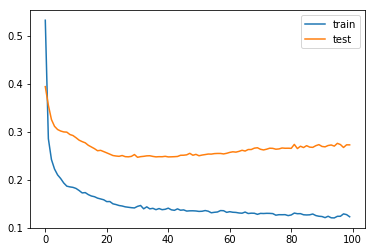

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show();

In [28]:
preds = model.predict(test_X)

In [34]:
preds

array([[0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.00793386],
       [0.47008783],
       [0.5229525 ],
       [0.3062626 ],
       [0.20894805],
       [0.18236732],
       [0.19930089],
       [0.17326926],
       [0.1285637 ],
       [0.09699477],
       [0.0733849 ],
       [0.0555676 ],
       [0.03985912],
       [0.02993091],
       [0.02544674],
       [0.02359802],
       [0.02197184],
       [0.01868455],
       [0.01402811],
       [0.01018772],
       [0.00819905],
       [0.00785502],
       [0.00877622],
       [0.01074877],
       [0.0136914 ],
       [0.01758681],
       [0.022

In [29]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_y,preds)

0.04967954035793567

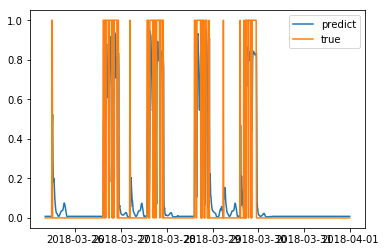

In [30]:
predictDates = trial_data.tail(len(test_X)).index

pyplot.plot(predictDates,preds, label='predict')
pyplot.plot(predictDates,test_y, label='true')
pyplot.legend()
pyplot.show()

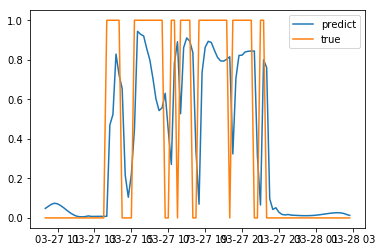

In [31]:

pyplot.plot(predictDates[300:400],preds[300:400], label='predict')
pyplot.plot(predictDates[300:400],test_y[300:400], label='true')
pyplot.legend()
pyplot.show()

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_y, preds))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.226


In [52]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    
    return preds_moving

In [57]:
preds_moving = moving_test_window_preds(1000)

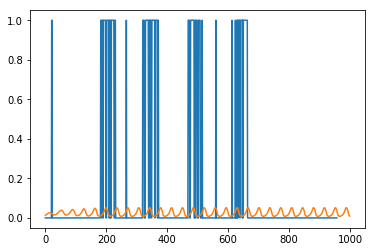

In [58]:
pyplot.plot(test_y)
pyplot.plot(preds_moving)
pyplot.show()